# Proyecto de Investigación
## Pablo Chantada Saborido (pablo.chantada@udc.es)
## Claudia Vidal Otero (claudia.votero@udc.es)
## Aldana Smyna (aldana.medina@udc.es)

# Preparación de los datos

Antes de abordar el problema tenemos que entender con que tipo de datos estamos tratando, para ello realizamos un leve estudio del nuestro conjunto de datos. El _dataset_ que utilizaremos está diseñado para clasificar seis actividades de la vida diaria realizadas por 30 individuos. Estas actividades son:  
__WALKING, WALKINGUPSTAIRS, WALKINGDOWNSTAIRS, SITTING, STANDING, LAYING__.

### Información general del _dataset_

- __Número de ejemplos:__ 10,299.  
- __Número de variables:__ 561.  
- __Tipos de datos:__  
  - __Enteros:__ identificadores.  
  - __Reales:__ Medidas numéricas.  
  - __Categóricos:__ Etiquetas de las actividades realizadas.  
- __Valores nulos:__ El _dataset_ incluye valores faltantes que deberán manejarse.

#### Descripción de las variables

1. __Identificador del sujeto:__ Variable entera que indica el participante que realizó la actividad.  
2. __Mediciones inerciales:__  
   - __Aceleración triaxial (x, y, z):__ Capturada por el acelerómetro, tanto la aceleración total como la componente filtrada (movimiento del cuerpo).  
   - __Velocidad angular triaxial (x, y, z):__ Capturada por el giroscopio.  
3. __Características derivadas:__  
   - Calculadas a partir de ventanas deslizantes de las señales.  
   - Variables en el dominio del tiempo y la frecuencia, que incluyen medidas estadísticas como medias, desviaciones estándar y correlaciones entre los ejes.  
4. __Etiqueta de la actividad:__ Variable categórica que representa la actividad realizada (_WALKING_, _SITTING_, etc.).

In [258]:
ENV["PYTHONWARNINGS"] = "ignore"
using PyCall
@pyimport warnings
warnings.filterwarnings("ignore")
using ScikitLearn
using ScikitLearn: fit!
using DataFrames
using CSV
using Random
using Plots
using DataFrames
using Statistics
using Test
using Distributions
using MLJ: predict
using Printf
using StatsBase: countmap

# Corregir las importaciones de scikit-learn
@sk_import feature_selection: (mutual_info_classif,)
@sk_import linear_model: (LogisticRegression,)
@sk_import preprocessing: (LabelEncoder,)
@sk_import decomposition: (PCA, FastICA)
@sk_import discriminant_analysis: (LinearDiscriminantAnalysis,)
@sk_import manifold: (Isomap, LocallyLinearEmbedding)

Random.seed!(172)

TaskLocalRNG()

### Funciones de Análisis

Para comprobar que los datos cargados sean los mismos que los del dataset, se implementan dos funciones básicas:

- `loadDataset()`: Carga el archivo CSV en memoria dado un PATH
- `csvDescription(csv)`: Imprime una descripción básica de las variables del dataset cargado y muestra la distribución de las clases
- `getNullValues(data)`: Analiza y muestra el porcentaje de valores nulos en el dataset

=== Dataset Description ===
Variables (excluding subject & Activity): 561
Total instances: 10299
Unique individuals: 30

Class distribution:
  WALKING_DOWNSTAIRS: 1406 instances (13.65%)
  SITTING: 1777 instances (17.25%)
  LAYING: 1944 instances (18.88%)
  STANDING: 1906 instances (18.51%)
  WALKING: 1722 instances (16.72%)
  WALKING_UPSTAIRS: 1544 instances (14.99%)


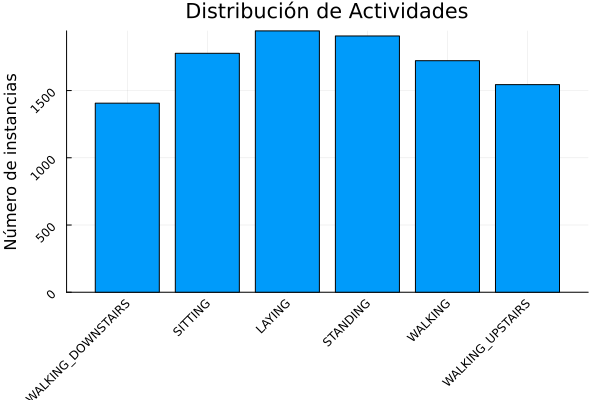

In [259]:
# =======================================
# Funcion de carga directa del DataSet
# =======================================

function loadDataset(PATH::String="../proyecto_investigacion/Datos_Práctica_Evaluación_1.csv")
    if !isfile(PATH)
        throw(ArgumentError("El archivo no existe en la ruta especificada"))
    end
    try
        return CSV.read(PATH, DataFrame)
    catch e
        error("Error al leer el archivo CSV: $e")
    end
end

# ============================
# Analisis leve del DataSet
# ============================

function csvDescription(df::DataFrame)
    println("=== Dataset Description ===")
    println("Variables (excluding subject & Activity): ", size(df, 2) - 2)  # Numero de columnas
    println("Total instances: ", size(df, 1))                               # Numero de filas
    println("Unique individuals: ", length(unique(df[:, 1])))               
    
    # Distribución de clases
    class_dist = countmap(df[:, end])
    activities = collect(keys(class_dist))
    counts = collect(values(class_dist))

    println("\nClass distribution:")
    for (class, count) in class_dist
        percentage = round(count/size(df,1)*100, digits=2)
        println("  $class: $count instances ($percentage%)")
    end
    # Imprimimos el grafico de las distribuciones
    p = bar(activities, 
            counts, 
            title="Distribución de Actividades",
            xlabel="Actividad",
            ylabel="Número de instancias",
            rotation=45, # Rotar etiquetas para mejor visualización
            legend=false)
    return p
end

dataset = loadDataset()
csvDescription(dataset)

In [260]:
# ============================
# Analisis leve de Nulos
# ============================
function getNullValues(data::DataFrame)
    println("=== Análisis de Valores Nulos ===")
    println("Total columnas: ", ncol(data))
    println("Total filas: ", nrow(data))
    # DataFrame con el análisis de nulos
    null_analysis = DataFrame(
        Columna = String[],
        Nulos = Int[],
        Porcentaje = Float64[]
    )
    total_nulls = 0
    # Analizar cada columna
    for col in names(data)
        n_nulls = sum(ismissing.(data[:, col]))
        total_nulls += n_nulls
        
        if n_nulls > 0
            push!(null_analysis, (
                col,
                n_nulls,
                (n_nulls / nrow(data)) * 100
            ))
        end
    end

    println("\nColumnas con valores nulos:")
    if !isempty(null_analysis)
        # Calcular y mostrar estadísticas globales
        total_elements = nrow(data) * ncol(data)
        total_pct_nulls = (total_nulls / total_elements) * 100
        println("\n=== Resumen Global ===")
        println("Total de valores nulos: $total_nulls")
        println("Porcentaje global de nulos: $(round(total_pct_nulls, digits=5))%")
        println("Columnas afectadas: $(nrow(null_analysis)) de $(ncol(data))")
        
        return null_analysis
    else
        return "\n No se encontraron valores nulos en ninguna columna"
    end

end

getNullValues(dataset)


=== Análisis de Valores Nulos ===
Total columnas: 563
Total filas: 10299

Columnas con valores nulos:

=== Resumen Global ===
Total de valores nulos: 270
Porcentaje global de nulos: 0.00466%
Columnas afectadas: 131 de 563


Row,Columna,Nulos,Porcentaje
,String,Int64,Float64
1,tBodyAcc-std()-X,2,0.0194194
2,tBodyAcc-std()-Z,2,0.0194194
3,tBodyAcc-mad()-X,2,0.0194194
4,tBodyAcc-mad()-Y,3,0.029129
5,tBodyAcc-mad()-Z,3,0.029129
6,tBodyAcc-max()-X,2,0.0194194
7,tBodyAcc-max()-Z,1,0.00970968
8,tBodyAcc-sma(),1,0.00970968
9,tBodyAcc-iqr()-X,3,0.029129


Los resultados confirman que el dataset está cargado correctamente conforme a la descripción:
- 561 variables
- 10,299 instancias
- 30 individuos  
- 6 clases de actividades

Podemos confirmar que no existe desbalanceo de clases significativo, teniendo todas aproximadamente la misma distribución con desviaciones entre el 2-5%. Además, tras el análisis de valores nulos encontramos:
- Total de valores nulos: 270
- Porcentaje global de nulos: 0.00466%
- Columnas afectadas: 131 de 563

Dado el ínfimo porcentaje de valores nulos, una simple interpolación será suficiente para rellenar las secciones faltantes del dataset.

## Preprocesado de los Datos

Tras realizar el análisis inicial, procedemos a preparar los datos para el entrenamiento de nuestros modelos. Este proceso consiste en cuatro etapas principales:
1. División de los datos mediante HoldOut (10%)
2. Codificación y tratamiento de valores nulos usando el conjunto de entrenamiento
3. Creación de folds para validación cruzada
4. Normalización mediante MinMaxScaler

### División Train/Test (HoldOut)

Implementamos una división que reserva el 10% de los individuos para test. Esta división se realiza _individual-wise_ para evitar que datos del mismo sujeto aparezcan en diferentes conjuntos, lo que podría llevar a sobreestimación del rendimiento. 

In [261]:
"""
Realiza una división hold-out del dataset, separando un 10% de los individuos para test.
Mantiene todas las instancias de un mismo individuo en el mismo conjunto.
"""
function HoldOut(data::DataFrame)
    
    # Obtener individuos únicos
    individuals = unique(data.subject)
    n_individuals = length(individuals)
    test_size = floor(Int, 0.1 * n_individuals)
    
    # Seleccionar individuos de test aleatoriamente
    test_individuals = sort(shuffle(individuals)[1:test_size])
    
    # Realizar la división
    test = data[in.(data.subject, Ref(Set(test_individuals))), :]
    train = data[.!in.(data.subject, Ref(Set(test_individuals))), :]
    
    # Mostrar información sobre la división
    println("\n=== Hold-Out Split Information ===")
    println("Total individuals: ", n_individuals)
    println("Train individuals: ", n_individuals - test_size)
    println("Test individuals: ", test_size)
    println("Individuals in test set: ", test_individuals)
    println("\nDistribution:")
    println("Training set: ", size(train, 1), " instances (", round(size(train, 1)/size(data, 1)*100, digits=2), "%)")
    println("Test set: ", size(test, 1), " instances (", round(size(test, 1)/size(data, 1)*100, digits=2), "%)")
    
    # Verificar que no hay solapamiento de individuos
    @assert isempty(intersect(Set(train.subject), Set(test.subject))) "Error: Found overlapping individuals between train and test sets"
    
    return train, test
end

HoldOut

### Preparación de Datos

Esta función realiza dos transformaciones esenciales:
1. Codificación numérica de las actividades (variable categórica)
2. Tratamiento de valores nulos mediante interpolación usando solo información del conjunto de entrenamiento

Las transformaciones se calculan usando únicamente el conjunto de entrenamiento y luego se aplican al conjunto de test, para intentar rellenar el conjunto de test con datos lo mas reales posibles.

In [262]:
"""
Prepara los datos para su uso en técnicas de clasificación.
1. Codifica las actividades
2. Rellena valores nulos usando la media del conjunto de entrenamiento
"""
function prepareData!(train::DataFrame, test::DataFrame)
    # 1. Codificar variable categórica (Activity)
    activities = unique(train.Activity)
    Activity_dict = Dict(act => i for (i, act) in enumerate(activities))
    # Transformar directamente la columna Activity
    train.Activity = map(x -> Activity_dict[x], train.Activity)
    test.Activity = map(x -> Activity_dict[x], test.Activity)
    # 2. Rellenar valores nulos con la media del training
    for col in names(train)
        # Verificar nulos tanto en train como en test
        if any(ismissing.(train[:, col])) || any(ismissing.(test[:, col]))
            train_mean = mean(skipmissing(train[:, col]))
            train[!, col] = coalesce.(train[:, col], train_mean)
            test[!, col] = coalesce.(test[:, col], train_mean)
        end
    end
    return train, test, Activity_dict
end

prepareData!

### Creación de Folds para Cross-Validation

Implementa una división en 5 folds manteniendo la integridad de los individuos (todas las instancias de un mismo individuo permanecen en el mismo fold). La distribución se realiza de manera equilibrada para mantener aproximadamente el mismo número de individuos por fold.

In [263]:
"""
Realiza 5-Fold CV manteniendo los individuos juntos en cada fold.
Retorna un vector de tuplas (train, val) para cada fold.
"""
function createFolds(data::DataFrame, n_folds=5)
    # Obtener individuos únicos del conjunto de training
    individuals = unique(data.subject)
    n_individuals = length(individuals)
    
    # Distribuir los individuos de manera más equilibrada
    shuffled_individuals = shuffle(individuals)
    base_size = floor(Int, n_individuals/n_folds)
    extras = n_individuals % n_folds
    
    folds = Vector{Tuple{DataFrame,DataFrame}}()
    current_idx = 1
    
    for i in 1:n_folds
        # Calcular tamaño de este fold
        fold_size = base_size + (i <= extras ? 1 : 0)
        val_individuals = shuffled_individuals[current_idx:current_idx+fold_size-1]
        current_idx += fold_size
        
        # Crear fold de validación
        val_fold = data[in.(data.subject, Ref(Set(val_individuals))), :]
        # Crear fold de entrenamiento con el resto
        train_fold = data[.!in.(data.subject, Ref(Set(val_individuals))), :]
        
        push!(folds, (train_fold, val_fold))
        println("Fold $i:")
        println("  Train: $(length(unique(train_fold.subject))) individuos, $(size(train_fold,1)) instancias")
        println("  Val: $(length(val_individuals)) individuos ($(val_individuals)), $(size(val_fold,1)) instancias")
    end
    
    return folds
end

createFolds

### Normalización MinMaxScaler

Aplica la normalización MinMaxScaler a las variables numéricas, excluyendo el identificador del sujeto ('subject') y la variable objetivo ('Activity'). 

In [264]:
"""
Aplica MinMaxScaler a los datos de entrenamiento y validación
"""
function applyMinMaxScaler!(train_fold::DataFrame, val_fold::DataFrame)
    numeric_cols = setdiff(names(train_fold), ["subject", "Activity"])
    
    for col in numeric_cols
        train_min = minimum(train_fold[:, col])
        train_max = maximum(train_fold[:, col])
        
        train_fold[!, col] = (train_fold[:, col] .- train_min) ./ (train_max - train_min)
        val_fold[!, col] = (val_fold[:, col] .- train_min) ./ (train_max - train_min)
    end
end

applyMinMaxScaler!

### Pipeline de Preprocesado

Por último, para facilitar la creación de los experimentos se añade un _pipeline_ para realizar toda el preprocesado con una única funcion. La función retorna los folds preparados para el entrenamiento junto con el conjunto de test, manteniendo la integridad de los datos y evitando data leakage entre las diferentes etapas del proceso.

In [265]:
function processDataPipeline(dataset::DataFrame)
    # 1. División inicial train/test (10%)
    train_data, test_data = HoldOut(dataset);
    
    # 2. Preparación básica (codificación + nulos)
    train_data_prepared, test_data_prepared, _ = prepareData!(train_data, test_data);
    
    # 3. Crear los 5 folds
    println("\n=== CV Split Information ===")
    folds = createFolds(train_data_prepared);
    
    # 4. Para cada fold, aplicar MinMaxScaler independientemente
    for (i, (train_fold, val_fold)) in enumerate(folds)
        applyMinMaxScaler!(train_fold, val_fold)
    end
    
    return folds, test_data_prepared
end

train_folds, test_folds = processDataPipeline(dataset);


=== Hold-Out Split Information ===
Total individuals: 30
Train individuals: 27
Test individuals: 3
Individuals in test set: [1, 9, 16]

Distribution:
Training set: 9298 instances (90.28%)
Test set: 1001 instances (9.72%)

=== CV Split Information ===
Fold 1:
  Train: 21 individuos, 7325 instancias
  Val: 6 individuos ([2, 3, 26, 22, 10, 14]), 1973 instancias
Fold 2:
  Train: 21 individuos, 7142 instancias
  Val: 6 individuos ([21, 17, 20, 6, 24, 12]), 2156 instancias
Fold 3:
  Train: 22 individuos, 7510 instancias
  Val: 5 individuos ([25, 13, 11, 23, 18]), 1788 instancias
Fold 4:
  Train: 22 individuos, 7603 instancias
  Val: 5 individuos ([8, 19, 28, 29, 15]), 1695 instancias
Fold 5:
  Train: 22 individuos, 7612 instancias
  Val: 5 individuos ([30, 27, 5, 4, 7]), 1686 instancias


In [266]:
reduced_folds_use = true

true

# Creación de Modelos Básicos

In [267]:
"""
# Argumentos
- `data::DataFrame`: DataFrame con los datos
- `method::Symbol`: Método a aplicar (:none, :anova, :mutual_info, :rfe)
- `target_col::Symbol=:Activity`: Nombre de la columna objetivo
- `kwargs...`: Argumentos adicionales para el método específico

# Devuelve
- `DataFrame`: DataFrame con las características seleccionadas
- `Dict`: Métricas adicionales específicas del método
"""
function apply_dimensionality_filter(data::DataFrame, method::Symbol;
                                      info::Bool=false, target_col::Symbol=:Activity,
                                      kwargs...)
    if method == :none
        return no_reduction(data; kwargs...)
    elseif method == :anova
        return anova_filter(data, target_col; kwargs...)
    elseif method == :mutual_info
        return mutual_information_filter(data, target_col; kwargs...)
    elseif method == :rfe
        return rfe_logistic_regression(data, target_col; kwargs...)
    else
        error("Método de reducción no reconocido: $method")
    end
end

apply_dimensionality_filter

# No aplicar reducción

In [268]:
function no_reduction(data::DataFrame; info::Bool=false)
    if info
        println("No se aplica reducción de dimensionalidad")
        println("Dimensiones originales: $(size(data))")
    end
    
    return data, Dict()
end

no_reduction (generic function with 1 method)

# Filtrado Anova

In [269]:
"""
# Argumentos
- `data::DataFrame`: DataFrame con los datos
- `target_col::Symbol`: Nombre de la columna objetivo
- `alpha::Float64=0.05`: Nivel de significancia para el test ANOVA
- `info::Bool=true`: Si true, muestra información sobre el proceso

# Devuelve
- `DataFrame`: DataFrame con las características seleccionadas
- `Dict`: Diccionario con p-valores para cada característica
"""
function anova_filter(data::DataFrame, target_col::Symbol; 
                     alpha::Float64=0.05, 
                     info::Bool=false)
    try
        # Separar features y target, excluyendo 'subject'
        X = select(data, Not([:subject, target_col]))
        y = data[:, target_col]
        
        # Inicializar diccionario para p-valores
        p_values = Dict{String, Float64}()
        
        # Calcular ANOVA para cada característica
        for col in names(X)
            # Agrupar por clase
            grouped_data = groupby(data, target_col)
            groups = [df[!, col] for df in grouped_data]
            
            # Calcular estadísticas ANOVA
            f_stat, p_val = oneway_anova(groups)
            p_values[col] = p_val
        end
        
        # Seleccionar características significativas
        selected_features = [col for (col, p_val) in p_values if p_val < alpha]
        
        if info
            println("\nTotal de características: $(length(names(X)))")
            println("Características seleccionadas: $(length(selected_features))")
            println("Nivel de significancia (alpha): $alpha")
        end
        
        # Crear DataFrame reducido
        reduced_data = select(data, vcat([:subject, target_col], Symbol.(selected_features)))
        
        return reduced_data, p_values
        
    catch e
        error("Error en ANOVA filter: $e")
    end
end

"""
Calcula el estadístico F y p-valor para ANOVA de un factor.

# Argumentos
- `groups`: Vector de vectores, cada uno conteniendo los valores de un grupo

# Devuelve
- Tupla con (F-statistic, p-value)
"""
function oneway_anova(groups::Vector)
    # Calcular medias y media global
    n_groups = length(groups)
    means = [mean(g) for g in groups]
    grand_mean = mean(vcat(groups...))
    
    # Calcular de la variabilidad entre los grupos
    ss_between = sum(length(g) * (mean(g) - grand_mean)^2 for g in groups)
    df_between = n_groups - 1
    
    # Calcular de la variabilidad dentro de los grupos
    ss_within = sum(sum((x - mean(g))^2 for x in g) for g in groups)
    df_within = sum(length(g) - 1 for g in groups)
    
    # Calcular MS y estadístico F
    ms_between = ss_between / df_between
    ms_within = ss_within / df_within
    f_statistic = ms_between / ms_within
    
    # Calcular p-valor
    f_dist = FDist(df_between, df_within)
    p_value = 1 - cdf(f_dist, f_statistic)
    
    return f_statistic, p_value
end

oneway_anova

# Filtrado Mutual Information

In [270]:
"""
Aplica filtrado por Información Mutua para selección de características.

# Argumentos
- `data::DataFrame`: DataFrame con los datos
- `target_col::Symbol`: Nombre de la columna objetivo
- `threshold::Float64=0.05`: Umbral mínimo de información mutua
- `info::Bool=true`: Si true, muestra información sobre el proceso

# Retorno
- `DataFrame`: DataFrame con las características seleccionadas
- `Dict`: Diccionario con scores de información mutua para cada característica
"""
function mutual_information_filter(data::DataFrame, target_col::Symbol;
                                 threshold::Float64=0.05,
                                 info::Bool=false)
    try
        # Separar features y target
        X = Matrix(select(data, Not([:subject, target_col])))
        y = data[:, target_col]
        
        # Calcular scores de información mutua
        mi_scores = mutual_info_classif(X, y)
        
        # Crear diccionario de resultados
        feature_names = names(select(data, Not([:subject, target_col])))
        mi_dict = Dict(zip(feature_names, mi_scores))
        
        # Seleccionar características por encima del umbral
        selected_features = feature_names[mi_scores .> threshold]
        
        if info
            println("Total de características: $(length(feature_names))")
            println("Características seleccionadas: $(length(selected_features))")
            println("Umbral de información mutua: $threshold")
            println("\nRango de scores MI:")
            println("Mínimo: $(minimum(mi_scores))")
            println("Máximo: $(maximum(mi_scores))")
            println("Media: $(mean(mi_scores))")
        end
        
        # Crear DataFrame reducido
        reduced_data = select(data, vcat([:subject, target_col], Symbol.(selected_features)))
        
        return reduced_data, mi_dict
        
    catch e
        error("Error en Mutual Information filter: $e")
    end
end

mutual_information_filter

# Filtrado RFE con LogisticRegression

In [271]:
"""
Aplica RFE usando Regresión Logística como estimador.

# Argumentos
- `data::DataFrame`: DataFrame con los datos
- `target_col::Symbol`: Nombre de la columna objetivo
- `n_features::Int=50`: Número de características a seleccionar
- `step::Float64=0.5`: Proporción de características a eliminar en cada iteración
- `info::Bool=false`: Si true, muestra información sobre el proceso

# Devuelve
- `DataFrame`: DataFrame con las características seleccionadas
- `Dict`: Diccionario con rankings de características
"""
function rfe_logistic_regression(data::DataFrame, target_col::Symbol; 
                               n_features::Int=50, 
                               step::Float64=0.5,
                               info::Bool=false)
    try
        # Separar features y target, excluyendo 'subject'
        X = select(data, Not([:subject, target_col]))
        feature_names = names(X)
        X_matrix = Matrix(X)
        y = data[:, target_col]
        
        # Inicializar variables
        n_features_current = size(X_matrix, 2)
        features_to_keep = trues(n_features_current)
        rankings = Dict(name => 0 for name in feature_names)
        current_rank = 1
        
        if info
            println("\nIniciando RFE:")
            println("Características iniciales: ", n_features_current)
            println("Características objetivo: ", n_features)
            println("Paso de eliminación: ", step)
        end
        
        # Iterar hasta alcanzar el número deseado de características
        while n_features_current > n_features
            # Entrenar modelo con características actuales
            clf = LogisticRegression(multi_class="ovr", max_iter=1000)
            clf.fit(X_matrix[:, features_to_keep], y)
            
            # Obtener importancia de características
            if hasproperty(clf, :coef_)
                importance = vec(sum(abs.(clf.coef_), dims=1))
            else
                error("El modelo no proporciona coeficientes")
            end
            
            # Calcular número de características a eliminar
            n_to_drop = min(
                floor(Int, n_features_current * step),
                n_features_current - n_features
            )
            
            # Encontrar características menos importantes
            sorted_idx = sortperm(importance)
            features_to_drop = sorted_idx[1:n_to_drop]
            
            # Actualizar rankings
            current_features = findall(features_to_keep)
            for idx in current_features[features_to_drop]
                rankings[feature_names[idx]] = current_rank
            end
            current_rank += 1
            
            # Actualizar máscara de características
            mask_update = trues(n_features_current)
            mask_update[current_features[features_to_drop]] .= false
            features_to_keep .&= mask_update
            
            # Actualizar contador
            n_features_current -= n_to_drop
            
            if info
                println("Iteración completada: ", n_features_current, " características restantes")
            end
        end
        
        # Asignar ranking final a características restantes
        for (i, keep) in enumerate(features_to_keep)
            if keep
                rankings[feature_names[i]] = current_rank
            end
        end
        
        if info
            println("\nRFE completado:")
            println("Características seleccionadas: ", sum(features_to_keep))
            println("Rankings asignados: ", length(unique(values(rankings))))
        end
        
        # Crear DataFrame reducido
        selected_features = feature_names[features_to_keep]
        reduced_data = select(data, vcat([:subject, target_col], Symbol.(selected_features)))
        
        return reduced_data, rankings
        
    catch e
        error("Error en RFE: $e")
    end
end

rfe_logistic_regression

## Técnicas de Reducción

In [272]:
# Importar las técnicas necesarias
"""
Aplica diferentes técnicas de reducción de dimensionalidad a los folds.

# Argumentos
- `fold::Tuple{DataFrame,DataFrame}`: Un fold (train, validation)
- `method::Symbol`: Método de reducción (:none, :pca, :lda, :ica, :isomap, :lle)
- `target_col::Symbol=:Activity`: Nombre de la columna objetivo
- `n_components::Int=2`: Número de componentes a mantener

# Retorna
- Tupla con (train_reduced, val_reduced)
"""
function apply_dimensionality_reduction(
    fold::Tuple{DataFrame, DataFrame}, 
    method::Symbol; 
    target_col::Symbol = :Activity, 
    n_components::Int = 2
)
    train_fold, val_fold = fold

    # Separar features y target
    X_train = Matrix{Float64}(select(train_fold, Not([:subject, target_col])))
    y_train = train_fold[:, target_col]
    X_val = Matrix{Float64}(select(val_fold, Not([:subject, target_col])))
    y_val = val_fold[:, target_col]

    # Aplicar reducción
    if method == :none
        X_train_reduced = X_train[:, 1:2]
        X_val_reduced = X_val[:, 1:2]
    elseif method == :pca
        reducer = PCA(n_components = n_components)
        X_train_reduced = reducer.fit_transform(X_train)  # Usar método Python
        X_val_reduced = reducer.transform(X_val)          # Solo transform para validación
    elseif method == :lda
        reducer = LinearDiscriminantAnalysis(n_components = n_components)
        X_train_reduced = reducer.fit_transform(X_train, y_train)
        X_val_reduced = reducer.transform(X_val)
    elseif method == :ica
        reducer = FastICA(n_components = n_components)
        X_train_reduced = reducer.fit_transform(X_train)
        X_val_reduced = reducer.transform(X_val)
    elseif method == :isomap
        reducer = Isomap(n_components = n_components)
        X_train_reduced = reducer.fit_transform(X_train)
        X_val_reduced = reducer.transform(X_val)
    elseif method == :lle
        reducer = LocallyLinearEmbedding(n_components = n_components)
        X_train_reduced = reducer.fit_transform(X_train)
        X_val_reduced = reducer.transform(X_val)
    else
        error("Método de reducción no reconocido: $method")
    end

    # Crear DataFrames reducidos
    train_reduced = DataFrame(X_train_reduced, :auto)
    train_reduced.Activity = y_train
    train_reduced.subject = train_fold.subject

    val_reduced = DataFrame(X_val_reduced, :auto)
    val_reduced.Activity = y_val
    val_reduced.subject = val_fold.subject

    return train_reduced, val_reduced
end


apply_dimensionality_reduction

In [273]:
function evaluate_reduction_techniques(
    folds::Vector{Tuple{DataFrame, DataFrame}}, 
    test_data::DataFrame, 
    n_rows::Int = 100
)
    methods = [:none, :pca, :lda, :ica, :isomap, :lle]
    results = DataFrame(Fold = Int[], Method = String[], Accuracy = Float64[])
    
    for (i, fold) in enumerate(folds)
        println("\nProcesando fold $i...")
        
        for method in methods
            try
                # Reducir dimensionalidad
                train_reduced, val_reduced = apply_dimensionality_reduction(fold, method)
                
                # Preparar datos
                X_train = Matrix{Float64}(select(train_reduced, Not([:subject, :Activity])))
                y_train = Array(train_reduced.Activity)
                X_val = Matrix{Float64}(select(val_reduced, Not([:subject, :Activity])))
                y_val = Array(val_reduced.Activity)
                
                println("Shapes - X_train: $(size(X_train)), y_train: $(size(y_train))")
                println("Shapes - X_val: $(size(X_val)), y_val: $(size(y_val))")
                
                # Crear y entrenar el clasificador
                clf = LogisticRegression(max_iter = 1000)
                clf.fit(X_train, y_train)
                
                # Hacer predicciones
                y_pred = clf.predict(X_val)
                accuracy = mean(y_pred .== y_val)
                
                push!(results, (i, String(method), accuracy))
                println("  Método $method - Accuracy: $(round(accuracy, digits = 4))")
                
            catch e
                println("Error en fold $i, método $method:")
                println(e)
                bt = catch_backtrace()
                println("Backtrace:")
                display(stacktrace(bt))
                push!(results, (i, String(method), NaN))
            end
        end
    end
    
    if nrow(results) > 0
        avg_results = combine(
            groupby(results, :Method),
            :Accuracy => mean => :Mean_Accuracy,
            :Accuracy => std => :Std_Accuracy
        )
        sort!(avg_results, :Mean_Accuracy, rev = true)
        
        println("\nResultados promedio por método:")
        println(avg_results)
        return results, avg_results
    else
        println("\nNo hay resultados para procesar")
        return results, DataFrame(
            Method = String[], 
            Mean_Accuracy = Float64[], 
            Std_Accuracy = Float64[]
        )
    end
end


evaluate_reduction_techniques (generic function with 2 methods)

In [274]:
"""
Visualiza una técnica de reducción específica para un fold con datos reducidos.
"""
function plot_reduction_results(fold::Tuple{DataFrame,DataFrame}, method::Symbol, n_rows::Int=100)
    # Reducir el tamaño del fold primero
    # reduced_fold = reduce_fold_size(fold, n_rows)
    
    # Aplicar la reducción dimensional
    train_reduced, _ = apply_dimensionality_reduction(fold, method)
    
    p = scatter(train_reduced[:,1], train_reduced[:,2],
               group=train_reduced.Activity,
               title="Reducción usando $(method)",
               xlabel="Dimensión 1",
               ylabel="Dimensión 2",
               legend=:topright,
               markersize=4)
    
    return p
end

"""
Visualiza todas las técnicas de reducción para un fold con datos reducidos.
"""
function plot_all_reductions(fold::Tuple{DataFrame,DataFrame}, n_rows::Int=100)
    methods = [:none, :pca, :lda, :ica, :isomap, :lle]
    plots = []
    
    # Reducir el tamaño del fold una sola vez
    # reduced_fold = reduce_fold_size(fold, n_rows)
    
    for method in methods
        push!(plots, plot_reduction_results(fold, method))
    end
    
    # Crear layout 2x3
    final_plot = plot(plots...,
                     layout=(2,3),
                     size=(1500,800))
    
    return final_plot
end

plot_all_reductions

In [275]:
"""
Evalúa todas las técnicas de reducción en todos los folds con tamaño reducido.
"""
function evaluate_reduction_techniques(folds::Vector{Tuple{DataFrame,DataFrame}}, 
                                    test_data::DataFrame, 
                                    n_rows::Int=100)
    
    methods = [:none, :pca, :lda, :ica, :isomap, :lle]
    results = DataFrame(Fold = Int[], Method = String[], Accuracy = Float64[])
    
    for (i, fold) in enumerate(folds)
        println("\nProcesando fold $i...")
        
        for method in methods
            try
                # Reducir dimensionalidad
                train_reduced, val_reduced = apply_dimensionality_reduction(fold, method)
                
                # Preparar datos
                X_train = Matrix(select(train_reduced, Not([:subject, :Activity])))
                y_train = train_reduced.Activity
                X_val = Matrix(select(val_reduced, Not([:subject, :Activity])))
                y_val = val_reduced.Activity
                
                # Entrenar y evaluar
                clf = LogisticRegression(max_iter=1000)
                fit!(clf, X_train, y_train)
                y_pred = clf.predict(X_val)  # Simplemente usamos predict directamente
                accuracy = mean(y_pred .== y_val)
                
                push!(results, (i, String(method), accuracy))
                println("  Método $method - Accuracy: $(round(accuracy, digits=4))")
                
            catch e
                println("Error en fold $i, método $method: $e")
                push!(results, (i, String(method), NaN))
            end
        end
    end
    
    # Calcular y mostrar resultados promedio por método
    avg_results = combine(groupby(results, :Method),
                         :Accuracy => mean => :Mean_Accuracy,
                         :Accuracy => std => :Std_Accuracy)
    
    # Ordenar por precisión media descendente
    sort!(avg_results, :Mean_Accuracy, rev=true)
    
    println("\nResultados promedio por método:")
    println(avg_results)
    
    return results, avg_results
end

evaluate_reduction_techniques

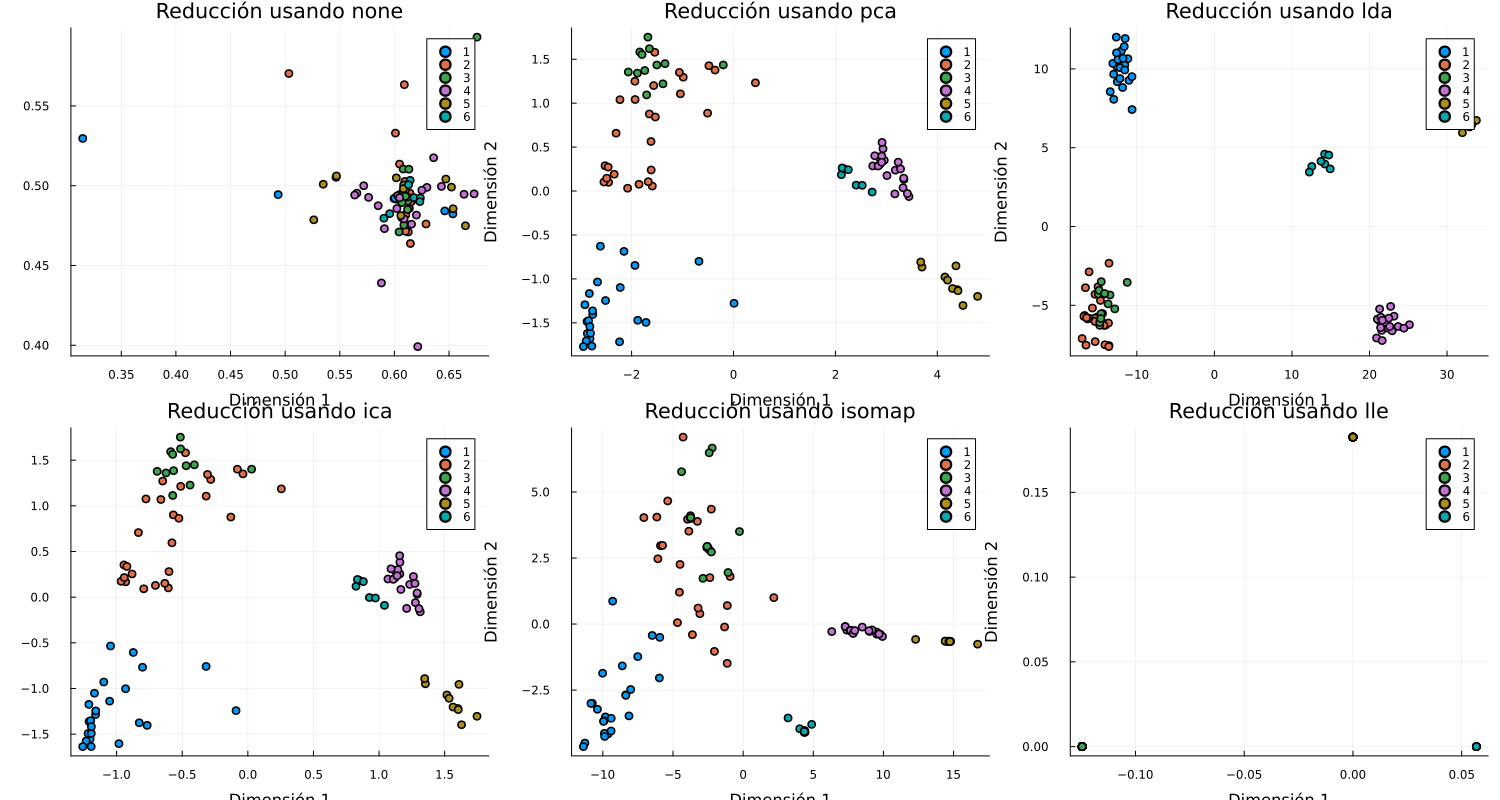

In [276]:
# results, avg_results = evaluate_reduction_techniques(train_folds, test_folds)

# Usamos solo el primer fold para sacar menos graficas
if reduced_folds_use == true
    reduced_folds = [(train[1:100, :], val[1:100, :]) for (train, val) in train_folds]
    fold = reduced_folds[1]
else
    fold = train_folds[1]
end
# Para visualizar todos los métodos
plot_all_reductions(fold)

## Clasificadores con las Técnicas de dimensionalidad

In [277]:
# Importar los clasificadores necesarios
@sk_import neural_network: MLPClassifier
@sk_import neighbors: KNeighborsClassifier
@sk_import svm: SVC
@sk_import metrics: f1_score

"""
Crea y evalúa múltiples clasificadores sobre datos reducidos.

# Argumentos
- `folds`: Vector de tuplas (train, val) con los folds
- `reduction_method`: Método de reducción usado (:none, :pca, etc.)
- `n_components`: Número de componentes usados en la reducción
"""

function evaluate_classifiers(
    folds::Vector{Tuple{DataFrame, DataFrame}}, 
    reduction_method::Symbol = :none,
    n_components::Int = 2
)
    # Mostrar información inicial
    classifiers = Dict(
        # MLPs con diferentes arquitecturas
        "MLP_50" => MLPClassifier(hidden_layer_sizes = (50,), max_iter = 1000, random_state = 42),
        "MLP_100" => MLPClassifier(hidden_layer_sizes = (100,), max_iter = 1000, random_state = 42),
        "MLP_100_50" => MLPClassifier(hidden_layer_sizes = (100, 50), max_iter = 1000, random_state = 42),
        
        # KNNs con diferentes números de vecinos
        "KNN_1" => KNeighborsClassifier(n_neighbors = 1),
        "KNN_10" => KNeighborsClassifier(n_neighbors = 10),
        "KNN_20" => KNeighborsClassifier(n_neighbors = 20),
        
        # SVMs con diferentes valores de C
        "SVM_0.1" => SVC(C = 0.1, random_state = 42),
        "SVM_0.5" => SVC(C = 0.5, random_state = 42),
        "SVM_1.0" => SVC(C = 1.0, random_state = 42)
    )
    
    results = DataFrame(
        Fold = Int[],
        Classifier = String[],
        Accuracy = Float64[],
        F1_Score = Float64[]
    )
    trained_models = Dict{String, Vector{Any}}()
    # Inicializar el diccionario de modelos entrenados
    for name in keys(classifiers)
        trained_models[name] = []
    end

    for (i, fold) in enumerate(folds)
        train_fold, val_fold = fold
        
        # Aplicar reducción de dimensionalidad
        train_reduced, val_reduced = apply_dimensionality_reduction(
            fold, reduction_method, n_components = n_components
        )
        
        # Preparar datos
        X_train = Matrix(select(train_reduced, Not([:subject, :Activity])))
        y_train = train_reduced.Activity
        X_val = Matrix(select(val_reduced, Not([:subject, :Activity])))
        y_val = val_reduced.Activity
        
        # Evaluar cada clasificador
        for (name, clf) in classifiers
            try
                clf_copy = deepcopy(clf)  # Crear una copia del clasificador
                fit!(clf_copy, X_train, y_train)
                y_pred = clf_copy.predict(X_val)
                accuracy = mean(y_pred .== y_val)
                f1 = f1_score(y_val, y_pred, average="weighted")
                push!(results, (i, name, accuracy, f1))
                push!(trained_models[name], clf_copy)  # Guardar el modelo entrenado
            catch e
                push!(results, (i, name, NaN, NaN))
                push!(trained_models[name], nothing)  # Guardar nothing en caso de error
            end
        end
    end
    
    if nrow(results) > 0
        stats = combine(
            groupby(results, :Classifier),
            :Accuracy => mean => :Mean_Accuracy,
            :Accuracy => std => :Std_Accuracy,
            :F1_Score => mean => :Mean_F1,
            :F1_Score => std => :Std_F1
        )
        sort!(stats, :Mean_Accuracy, rev=true)
        return results, stats, trained_models
    else
        return results, DataFrame(
            Classifier = String[],
            Mean_Accuracy = Float64[],
            Std_Accuracy = Float64[],
            Mean_F1 = Float64[],
            Std_F1 = Float64[]
        ), trained_models
    end
end

evaluate_classifiers (generic function with 3 methods)

In [278]:
"""
Evalúa todos los clasificadores con todas las técnicas de reducción.
"""
function evaluate_all_combinations(
    folds::Vector{Tuple{DataFrame, DataFrame}}, 
    reduction_methods = [:none, :pca, :lda, :ica, :isomap, :lle]
)
    all_results = DataFrame(
        Reduction = String[],
        Classifier = String[],
        Mean_Accuracy = Float64[],
        Std_Accuracy = Float64[],
        Mean_F1 = Float64[],    
        Std_F1 = Float64[]     
    )
    all_models = Dict{Symbol, Dict{String, Any}}()

    for method in reduction_methods
        # Evaluar clasificadores con el método de reducción actual
        results, stats, trained_models = evaluate_classifiers(folds, method)
        
        # Agregar método de reducción a las estadísticas
        transform!(stats, [] => ByRow(() -> String(method)) => :Reduction)
        append!(all_results, stats[:, [:Reduction, :Classifier, :Mean_Accuracy, :Std_Accuracy, :Mean_F1, :Std_F1]])
        
        # Guardar resultados, estadísticas y modelos
        all_models[method] = Dict(
            "Results" => results,
            "Stats" => stats,
            "Models" => trained_models
        )
    end
        
    # Ordenar resultados por precisión media
    sort!(all_results, :Mean_Accuracy, rev = true)
    
    # Imprimir top 10 de forma formateada
    println("\n=== TOP 10 MEJORES COMBINACIONES ===")
    println("=====================================")
    for (i, row) in enumerate(eachrow(first(all_results, 10)))
        println(
            @sprintf(
                "%2d. %-6s con %-10s → Acc: %.2f%% (±%.2f%%) F1: %.2f%% (±%.2f%%)",
                i,
                row.Reduction,
                row.Classifier,
                row.Mean_Accuracy * 100,
                row.Std_Accuracy * 100,
                row.Mean_F1 * 100,
                row.Std_F1 * 100
            )
        )
    end

    return all_results, all_models
end


evaluate_all_combinations

In [279]:
function get_best_models_overall(all_results::DataFrame, all_models::Dict)
    global_best = Dict()
    
    # Para cada tipo de modelo
    for model_type in ["MLP", "KNN", "SVM"]
        # Filtrar todos los resultados de este tipo de modelo
        type_results = filter(row -> startswith(row.Classifier, model_type), all_results)
        
        if nrow(type_results) > 0
            # Encontrar la mejor fila basada en precisión media
            best_row = type_results[argmax(type_results.Mean_Accuracy), :]
            
            # Obtener el método de reducción y nombre del clasificador
            reduction = Symbol(best_row.Reduction)
            classifier_name = best_row.Classifier
            
            # Guardar la información del mejor modelo
            global_best[model_type] = Dict(
                "reduction" => reduction,
                "name" => classifier_name,
                "metrics" => best_row,
                "model" => all_models[reduction]["Models"][classifier_name]
            )
        end
    end
    
    return global_best
end

get_best_models_overall (generic function with 1 method)

# PipeLine de Modelos Basicos

In [280]:
if reduced_folds_use == true
    reduced_folds = [(train[1:100, :], val[1:100, :]) for (train, val) in train_folds]
    all_results, all_models = evaluate_all_combinations(reduced_folds)
else
    all_results, all_models = evaluate_all_combinations(train_folds)
end 

best_models_overall = get_best_models_overall(all_results, all_models)

# Mostrar los resultados
println("\n=== MEJORES MODELOS GLOBALES POR TIPO ===")
for (model_type, info) in best_models_overall
    metrics = info["metrics"]
    println("$model_type: $(info["reduction"]) con $(info["name"]) → " *
           "Acc: $(round(metrics.Mean_Accuracy*100, digits=2))% " *
           "(±$(round(metrics.Std_Accuracy*100, digits=2))%) " *
           "F1: $(round(metrics.Mean_F1*100, digits=2))% " *
           "(±$(round(metrics.Std_F1*100, digits=2))%)")
end


=== TOP 10 MEJORES COMBINACIONES ===
 1. lle    con KNN_1      → Acc: 80.40% (±5.94%) F1: 79.72% (±6.22%)
 2. lle    con KNN_10     → Acc: 80.20% (±5.22%) F1: 78.11% (±6.07%)
 3. lle    con KNN_20     → Acc: 78.60% (±7.99%) F1: 75.82% (±9.49%)
 4. lda    con SVM_0.5    → Acc: 77.60% (±10.81%) F1: 74.26% (±12.57%)
 5. lda    con SVM_1.0    → Acc: 75.20% (±9.60%) F1: 71.25% (±11.33%)
 6. lda    con KNN_1      → Acc: 75.00% (±9.62%) F1: 72.10% (±9.29%)
 7. lda    con KNN_20     → Acc: 74.60% (±11.08%) F1: 71.01% (±12.12%)
 8. lda    con KNN_10     → Acc: 74.20% (±9.68%) F1: 70.83% (±10.06%)
 9. isomap con MLP_100_50 → Acc: 71.00% (±3.32%) F1: 69.69% (±3.73%)
10. lda    con MLP_50     → Acc: 70.60% (±12.26%) F1: 67.80% (±12.87%)

=== MEJORES MODELOS GLOBALES POR TIPO ===
SVM: lda con SVM_0.5 → Acc: 77.6% (±10.81%) F1: 74.26% (±12.57%)
MLP: isomap con MLP_100_50 → Acc: 71.0% (±3.32%) F1: 69.69% (±3.73%)
KNN: lle con KNN_1 → Acc: 80.4% (±5.94%) F1: 79.72% (±6.22%)


## Plot comparativo de los modelos

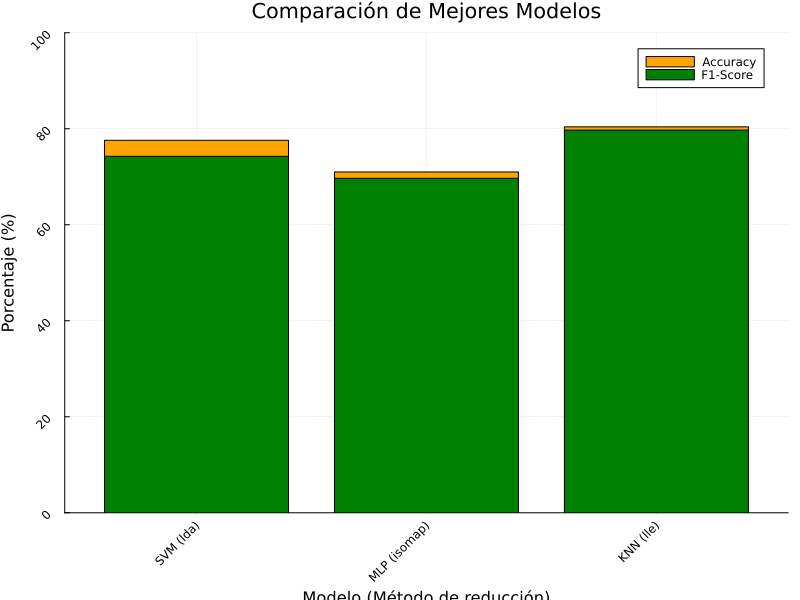

In [281]:
function plot_model_comparison(best_models_overall)
    # Extraer nombres y métricas
    model_names = collect(keys(best_models_overall))
    accuracies = [best_models_overall[m]["metrics"].Mean_Accuracy * 100 for m in model_names]
    f1_scores = [best_models_overall[m]["metrics"].Mean_F1 * 100 for m in model_names]
    
    # Crear etiquetas que incluyan el método de reducción
    labels = ["$name ($(best_models_overall[name]["reduction"]))" for name in model_names]
    
    # Graficar barras lado a lado
    bar(
        labels,
        [accuracies f1_scores],
        label = ["Accuracy" "F1-Score"],
        legend = :topright,
        bar_position = :dodge,
        c = [:orange :green],
        title = "Comparación de Mejores Modelos",
        xlabel = "Modelo (Método de reducción)",
        ylabel = "Porcentaje (%)",
        ylims = (0, 100),
        rotation = 45,  # Rotar etiquetas para mejor legibilidad
        size = (800, 600)  # Tamaño del gráfico
    )
end

# Ejemplo de uso:
p = plot_model_comparison(best_models_overall)
display(p)

# Modelos Ensemble



In [282]:
# Registrar modelos
@sk_import ensemble: BaggingClassifier
@sk_import neighbors: KNeighborsClassifier
@sk_import ensemble: AdaBoostClassifier
@sk_import svm: SVC
@sk_import ensemble: GradientBoostingClassifier

# ===========================================
# Función para entrenar BaggingClassifier con KNN
# ===========================================
function train_bagging_knn(X, y; n_estimators=10)
    X_matrix = Matrix(X)
    
    base_knn = KNeighborsClassifier(n_neighbors=5)
    
    bagging = BaggingClassifier(
        estimator=base_knn,
        n_estimators=n_estimators,
        random_state=42
    )
    
    fit!(bagging, X_matrix, y)
    return bagging
end

# ===========================================
# Función para entrenar AdaBoost con SVM
# ===========================================
function train_adaboost_svm(X, y)
    X_matrix = Matrix(X)
    
    base_svm = SVC(kernel="linear", probability=true)
    
    ada = AdaBoostClassifier(
        estimator=base_svm,
        n_estimators=5,
        random_state=42
    )
    
    fit!(ada, X_matrix, y)
    return ada
end

# ===========================================
# Función para entrenar GradientBoosting
# ===========================================
function train_gbm(X, y)
    X_matrix = Matrix(X)
    
    gbm = GradientBoostingClassifier(
        n_estimators=50,
        learning_rate=0.2,
        random_state=42
    )
    
    fit!(gbm, X_matrix, y)
    return gbm
end

train_gbm (generic function with 1 method)

In [283]:

# ===========================================
# Función principal para entrenar todos los modelos
# ===========================================
function train_ensemble_models(fold; verbose=true)
    # Desempaquetar el fold
    train_fold, val_fold = fold
    
    # Preparar los datos
    if verbose
        println("\nPreparando datos...")
    end
    
    # Filtrar los datos
    X_train = Matrix{Float64}(select(train_fold, Not([:subject, :Activity])))
    y_train = train_fold[!, :Activity]
    X_test = Matrix{Float64}(select(val_fold, Not([:subject, :Activity])))
    y_test = val_fold[!, :Activity]
    
    models = Dict()
    results = Dict()
    
    # Entrenar modelos
    if verbose
        println("\nEntrenando modelos...")
    end
    
    # Bagging KNN (10 estimadores)
    if verbose
        println("Entrenando Bagging KNN (10 estimadores)...")
    end
    models["bagging_knn_10"] = train_bagging_knn(X_train, y_train, n_estimators=10)
    
    # Bagging KNN (50 estimadores)
    if verbose
        println("Entrenando Bagging KNN (50 estimadores)...")
    end
    models["bagging_knn_50"] = train_bagging_knn(X_train, y_train, n_estimators=50)
    
    # AdaBoost SVM
    if verbose
        println("Entrenando AdaBoost SVM...")
    end
    models["adaboost_svm"] = train_adaboost_svm(X_train, y_train)
    
    # GBM
    if verbose
        println("Entrenando GBM...")
    end
    models["gbm"] = train_gbm(X_train, y_train)
    
    # Evaluación de modelos
    if verbose
        println("\nEvaluando modelos...")
    end
    
    for (name, model) in models
        y_pred = model.predict(X_test)
        accuracy = mean(y_pred .== y_test)
        f1 = f1_score(y_test, y_pred, average="weighted")  # Ahora usamos el f1_score de scikit-learn
        results[name] = Dict("accuracy" => accuracy, "f1" => f1)
        
        if verbose
            println(" - $name: Accuracy = $(round(accuracy, digits=4)), F1 = $(round(f1, digits=4))")
        end
    end
    
    return models, results
end

train_ensemble_models (generic function with 1 method)

In [284]:
function ensemble_pipeline(folds; verbose=true)
    all_results = []
    all_models = Dict()
    trained_models = Dict{String, Vector{Any}}()  # Para guardar los modelos por nombre
    
    # Inicializar los vectores de modelos entrenados
    first_fold_models, _ = train_ensemble_models(folds[1], verbose=false)
    for model_name in keys(first_fold_models)
        trained_models[model_name] = []
    end

    for (i, fold) in enumerate(folds)
        if verbose
            println("\nProcesando fold $i de $(length(folds))...")
            println("----------------------------------------")
            train_fold, val_fold = fold
            println("Tamaño conjunto entrenamiento: $(size(train_fold, 1)) muestras")
            println("Tamaño conjunto test: $(size(val_fold, 1)) muestras")
        end
        
        # Entrenar modelos y obtener resultados
        fold_models, fold_results = train_ensemble_models(fold, verbose=verbose)
        
        # Guardar resultados y modelos
        push!(all_results, fold_results)
        all_models[i] = fold_models
        
        # Guardar los modelos entrenados por nombre
        for (model_name, model) in fold_models
            push!(trained_models[model_name], model)
        end

        if verbose
            println("\nResultados fold $i:")
            for (model, metrics) in fold_results
                println(" - $model: acc=$(round(metrics["accuracy"], digits=4)), f1=$(round(metrics["f1"], digits=4))")
            end
        end
    end

    # Calcular estadísticas finales y guardar información de los mejores folds
    stats = Dict()
    if verbose
        println("\nCalculando estadísticas finales...")
    end
    
    for model_name in keys(all_results[1])
        accuracies = [result[model_name]["accuracy"] for result in all_results]
        f1_scores = [result[model_name]["f1"] for result in all_results]
        best_fold_idx = argmax(accuracies)
        
        stats[model_name] = Dict(
            "mean_accuracy" => mean(accuracies),
            "std_accuracy" => std(accuracies),
            "min_accuracy" => minimum(accuracies),
            "max_accuracy" => maximum(accuracies),
            "mean_f1" => mean(f1_scores),
            "std_f1" => std(f1_scores),
            "best_fold" => best_fold_idx,
            "best_model" => trained_models[model_name][best_fold_idx]
        )
    end

    return stats, trained_models
end

ensemble_pipeline (generic function with 1 method)

In [285]:
if reduced_folds_use == true
    reduced_folds = [(train[1:100, :], val[1:100, :]) for (train, val) in train_folds]
    stats, models = ensemble_pipeline(reduced_folds, verbose=true)
else
    stats, models = ensemble_pipeline(train_folds, verbose=true)
end


Procesando fold 1 de 5...
----------------------------------------
Tamaño conjunto entrenamiento: 100 muestras
Tamaño conjunto test: 100 muestras

Preparando datos...

Entrenando modelos...
Entrenando Bagging KNN (10 estimadores)...
Entrenando Bagging KNN (50 estimadores)...
Entrenando AdaBoost SVM...
Entrenando GBM...

Evaluando modelos...
 - bagging_knn_10: Accuracy = 0.82, F1 = 0.796
 - bagging_knn_50: Accuracy = 0.81, F1 = 0.7808
 - gbm: Accuracy = 0.54, F1 = 0.4818
 - adaboost_svm: Accuracy = 0.64, F1 = 0.526

Resultados fold 1:
 - bagging_knn_10: acc=0.82, f1=0.796
 - bagging_knn_50: acc=0.81, f1=0.7808
 - gbm: acc=0.54, f1=0.4818
 - adaboost_svm: acc=0.64, f1=0.526

Procesando fold 2 de 5...
----------------------------------------
Tamaño conjunto entrenamiento: 100 muestras
Tamaño conjunto test: 100 muestras

Preparando datos...

Entrenando modelos...
Entrenando Bagging KNN (10 estimadores)...
Entrenando Bagging KNN (50 estimadores)...
Entrenando AdaBoost SVM...
Entrenando GBM

(Dict{Any, Any}("bagging_knn_10" => Dict{String, Any}("min_accuracy" => 0.75, "best_model" => PyObject BaggingClassifier(estimator=KNeighborsClassifier(), random_state=42), "std_f1" => 0.07430474537024588, "mean_accuracy" => 0.82, "std_accuracy" => 0.06204836822995429, "max_accuracy" => 0.92, "best_fold" => 4, "mean_f1" => 0.7953507178358337), "bagging_knn_50" => Dict{String, Any}("min_accuracy" => 0.75, "best_model" => PyObject BaggingClassifier(estimator=KNeighborsClassifier(), n_estimators=50,
                  random_state=42), "std_f1" => 0.08348829648390765, "mean_accuracy" => 0.826, "std_accuracy" => 0.0709224929059886, "max_accuracy" => 0.93, "best_fold" => 4, "mean_f1" => 0.8004281949709714), "gbm" => Dict{String, Any}("min_accuracy" => 0.37, "best_model" => PyObject GradientBoostingClassifier(learning_rate=0.2, n_estimators=50, random_state=42), "std_f1" => 0.1497973384987376, "mean_accuracy" => 0.516, "std_accuracy" => 0.12856904759700136, "max_accuracy" => 0.67, "best_fold"

In [286]:
# Función para obtener el tipo de modelo base de forma más general
function get_model_type(model_name::String)
    if startswith(model_name, "bagging_knn")
        return "Bagging KNN"
    elseif startswith(model_name, "adaboost")
        return "AdaBoost SVM"
    elseif startswith(model_name, "gbm")
        return "GBM"
    else
        return "Unknown"
    end
end

results_df = DataFrame(
    Model = String[],
    Mean_Accuracy = Float64[],
    Max_Accuracy = Float64[],
    Best_Fold = Int[],
    Mean_F1 = Float64[],
    Std_F1 = Float64[]
)

for (model_name, metrics) in stats
    push!(results_df, [
        model_name,
        metrics["mean_accuracy"],
        metrics["max_accuracy"],
        metrics["best_fold"],
        metrics["mean_f1"],
        metrics["std_f1"]
    ])
end

# Añadir columna con el tipo de modelo
results_df.ModelType = get_model_type.(results_df.Model)

# Obtener el mejor modelo de cada tipo
best_models = combine(groupby(results_df, :ModelType)) do group
    sort(group, :Max_Accuracy, rev=true)[1, :]
end

# Para cada mejor modelo, puedes acceder al modelo entrenado:
for row in eachrow(best_models)
    best_model = stats[row.Model]["best_model"]
    println("Mejor modelo para $(row.ModelType): accuracy=$(row.Max_Accuracy), f1=$(row.Max_Accuracy) (fold $(row.Best_Fold))")
end

Mejor modelo para Bagging KNN: accuracy=0.93, f1=0.93 (fold 4)
Mejor modelo para GBM: accuracy=0.67, f1=0.67 (fold 2)
Mejor modelo para AdaBoost SVM: accuracy=0.79, f1=0.79 (fold 4)


# Plot de Basicos

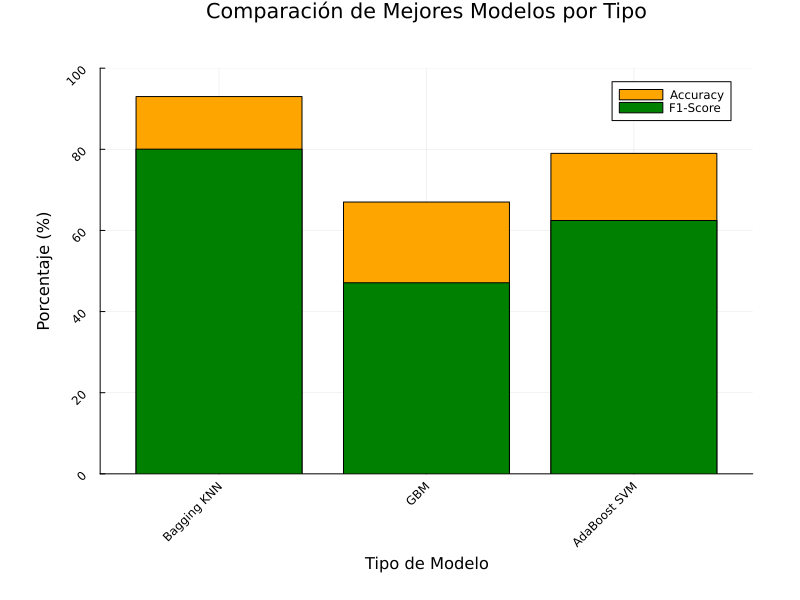

In [287]:
using Plots

function plot_model_comparison(results_df)
    # Agrupar por tipo de modelo y obtener el mejor de cada tipo
    best_models = combine(groupby(results_df, :ModelType)) do group
        sort(group, :Max_Accuracy, rev=true)[1, :]
    end
    
    # Extraer datos para el gráfico
    model_types = best_models.ModelType
    accuracies = best_models.Max_Accuracy .* 100  # Convertir a porcentaje
    f1_scores = best_models.Mean_F1 .* 100        # Convertir a porcentaje
    
    # Crear el gráfico
    bar(
        model_types,
        [accuracies f1_scores],
        label = ["Accuracy" "F1-Score"],
        legend = :topright,
        bar_position = :dodge,
        c = [:orange :green],
        title = "Comparación de Mejores Modelos por Tipo",
        xlabel = "Tipo de Modelo",
        ylabel = "Porcentaje (%)",
        ylims = (0, 100),
        rotation = 45,
        size = (800, 600),
        margin = 10Plots.mm
    )
end

# Usar la función
p = plot_model_comparison(results_df)
display(p)

# Conjunto Completo

In [288]:
using ScikitLearn
using MLJ: predict
using Statistics: mean, std
# using CatBoost
using XGBoost: xgboost, predict as xgb_predict
# using LightGBM: LGBMClassifier, fit! as lgbm_fit!, predict as lgbm_predict

In [289]:
# Importar los modelos necesarios
@sk_import ensemble: (RandomForestClassifier, VotingClassifier, StackingClassifier)
@sk_import ensemble: AdaBoostClassifier
@sk_import metrics: f1_score

PyObject <function f1_score at 0x755f5801ae80>

In [290]:
function create_base_ensemble_models(X_train, y_train, stats, results_df)
    models = Dict()

    # Obtener los mejores modelos de cada tipo
    best_models_dict = Dict()
    cv_scores = Float64[]
    
    # Mapeo de tipos de modelos
    model_types = ["Bagging KNN", "AdaBoost SVM", "GBM"]
    
    println("\nSeleccionando mejores modelos:")
    println("============================")
    
    for model_type in model_types
        # Filtrar modelos de este tipo
        type_models = filter(r -> r.ModelType == model_type, results_df)
        
        if !isempty(type_models)
            # Ordenar por precisión y tomar el mejor
            best_model_row = sort(type_models, :Max_Accuracy, rev=true)[1, :]
            model_name = best_model_row.Model
            
            # Guardar el mejor modelo y su score
            best_models_dict[model_type] = stats[model_name]["best_model"]
            push!(cv_scores, best_model_row.Max_Accuracy)
            
            println("Mejor $model_type: $model_name (Accuracy: $(round(best_model_row.Max_Accuracy * 100, digits=2))%)")
        else
            @warn "No se encontraron modelos de tipo $model_type"
        end
    end
    
    # Random Forest
    println("\nCreando Random Forest...")
    rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=10,
        random_state=172
    )
    ScikitLearn.fit!(rf, X_train, y_train)
    models["random_forest"] = rf
    
    # Hard Voting
    println("Creando Hard Voting Classifier...")
    estimators = [
        ("bagging", best_models_dict["Bagging KNN"]),
        ("adaboost", best_models_dict["AdaBoost SVM"]),
        ("gbm", best_models_dict["GBM"])
    ]
    
    hard_voting = VotingClassifier(
        estimators=estimators,
        voting="hard"
    )
    ScikitLearn.fit!(hard_voting, X_train, y_train)
    models["hard_voting"] = hard_voting
    
    # Soft Voting
    println("Creando Soft Voting Classifier...")
    soft_voting = VotingClassifier(
        estimators=estimators,
        voting="soft",
        weights=cv_scores
    )
    ScikitLearn.fit!(soft_voting, X_train, y_train)
    models["soft_voting"] = soft_voting
    
    # Stacking
    println("Creando Stacking Classifier...")
    stacking = StackingClassifier(
        estimators=estimators,
        final_estimator=best_models_dict["GBM"],
        cv=5
    )
    ScikitLearn.fit!(stacking, X_train, y_train)
    models["stacking"] = stacking
    #=
    
    # XGBoost con valores por defecto
    println("Creando XGBoost...")
    xgb = xgboost(
        objective="multi:softmax",
        num_class=length(unique(y_train)),
        max_depth=6,
        eta=0.3,
        num_round=100
    )
    ScikitLearn.fit!(xgb, X_train, y_train)
    models["xgboost"] = xgb

    # LightGBM con valores por defecto
    println("Creando LightGBM...")
    lgbm = LGBMClassifier()
    lgbm_fit!(lgbm, X_train, y_train)
    models["lightgbm"] = lgbm

    # CatBoost con valores por defecto
    println("Creando CatBoost...")
    cb = CatBoostClassifier(random_seed=172)
    CatBoost.fit!(cb, X_train, y_train)  # CatBoost aún necesita el namespace completo
    models["catboost"] = cb
    =#

    return models
end

create_base_ensemble_models (generic function with 1 method)

In [291]:
function evaluate_ensemble_models(models, test_data)
    # Preparar datos de test
    X_test = Matrix{Float64}(select(test_data, Not([:subject, :Activity])))
    y_test = test_data.Activity
    
    results = Dict()
    
    println("\nEvaluación en conjunto de test (10% reservado):")
    println("===============================================")
    
    for (name, model) in models
        try
            if name == "xgboost"
                y_pred = xgb_predict(X_test)
            else
                y_pred = model.predict(X_test)
            end
            accuracy = mean(y_pred .== y_test)
            f1 = f1_score(y_test, y_pred, average="weighted")
            
            results[name] = Dict(
                "accuracy" => accuracy,
                "f1_score" => f1
            )
            
            println("$name:")
            println("  - Accuracy: $(round(accuracy * 100, digits=2))%")
            println("  - F1-Score: $(round(f1 * 100, digits=2))%")
        catch e
            println("Error evaluando $name: $e")
            println("Error completo: ")
            println(e)
        end
    end
    
    return results
end

"""
Pipeline completo para entrenar con todos los folds y evaluar con el conjunto de test reservado.
"""
function train_and_evaluate_ensembles(train_folds, test_data, stats, results_df)
    println("\nPreparando datos...")
    println("==================")
    
    # Combinar todos los folds de entrenamiento
    complete_train = combine_folds(train_folds)
    println("Total de instancias de entrenamiento: $(size(complete_train, 1))")
    println("Total de instancias de test: $(size(test_data, 1))")
    
    # Preparar datos de entrenamiento
    X_train = Matrix{Float64}(select(complete_train, Not([:subject, :Activity])))
    y_train = complete_train.Activity
    
    # Crear y entrenar modelos
    println("\nCreando y entrenando modelos ensemble...")
    println("=====================================")
    models = create_base_ensemble_models(X_train, y_train, stats, results_df)
    
    # Evaluar modelos
    results = evaluate_ensemble_models(models, test_data)
    
    return models, results
end

train_and_evaluate_ensembles

In [292]:
# Para tomar una muestra más pequeña, deberías hacer algo así:
function sample_folds(train_folds, n_train=1000)
    sampled_folds = Vector{Tuple{DataFrame, DataFrame}}()
    
    for (train_fold, val_fold) in train_folds
        # Tomar muestra del conjunto de entrenamiento
        sampled_train = first(train_fold, min(n_train, nrow(train_fold)))
        sampled_val = first(val_fold, min(n_train ÷ 5, nrow(val_fold)))
        
        push!(sampled_folds, (sampled_train, sampled_val))
    end
    
    return sampled_folds
end

function combine_folds(train_folds)
    # Extraer todos los conjuntos de entrenamiento
    all_train_data = [train_fold for (train_fold, _) in train_folds]
    
    # Combinar en un único DataFrame
    return vcat(all_train_data...)
end

# Y luego usar:
sampled_train_folds = sample_folds(train_folds, 100)
sampled_test = first(test_folds, 100)

# Ahora sí puedes ejecutar:
models, results = train_and_evaluate_ensembles(sampled_train_folds, sampled_test, stats, results_df)


Preparando datos...
Total de instancias de entrenamiento: 500
Total de instancias de test: 100

Creando y entrenando modelos ensemble...

Seleccionando mejores modelos:
Mejor Bagging KNN: bagging_knn_50 (Accuracy: 93.0%)
Mejor AdaBoost SVM: adaboost_svm (Accuracy: 79.0%)
Mejor GBM: gbm (Accuracy: 67.0%)

Creando Random Forest...
Creando Hard Voting Classifier...
Creando Soft Voting Classifier...
Creando Stacking Classifier...

Evaluación en conjunto de test (10% reservado):
hard_voting:
  - Accuracy: 43.0%
  - F1-Score: 36.31%
random_forest:
  - Accuracy: 46.0%
  - F1-Score: 33.58%
soft_voting:
  - Accuracy: 62.0%
  - F1-Score: 57.73%
stacking:
  - Accuracy: 62.0%
  - F1-Score: 58.54%


(Dict{Any, Any}("hard_voting" => PyObject VotingClassifier(estimators=[('bagging',
                              BaggingClassifier(estimator=KNeighborsClassifier(),
                                                n_estimators=50,
                                                random_state=42)),
                             ('adaboost',
                              AdaBoostClassifier(estimator=SVC(kernel='linear',
                                                               probability=True),
                                                 n_estimators=5,
                                                 random_state=42)),
                             ('gbm',
                              GradientBoostingClassifier(learning_rate=0.2,
                                                         n_estimators=50,
                                                         random_state=42))]), "random_forest" => PyObject RandomForestClassifier(max_depth=10, n_estimators=500, random_state=172),

In [293]:
function convert_results_to_dataframe(results)
    df = DataFrame(
        Modelo = String[],
        Accuracy = Float64[],
        F1_Score = Float64[]
    )
    for (modelo, metricas) in results
        acc = get(metricas, "accuracy", missing)
        f1 = get(metricas, "f1_score", missing)
        push!(df, (modelo, acc, f1))
    end
    return df
end

function mostrar_top_n_modelos(results, n=10; sort_metric="accuracy")
    # Convertir el Dict a DataFrame
    df = convert_results_to_dataframe(results)
    
    # Ya no necesitamos renombrar porque las columnas ya tienen los nombres correctos
    # Las columnas ya son "Modelo", "Accuracy" y "F1_Score"
    
    # Verificar que la métrica de ordenamiento exista
    valid_metrics = ["Accuracy", "F1_Score"]
    if !(sort_metric in valid_metrics)
        @warn "Métrica '$sort_metric' no encontrada. Se usará 'Accuracy' por defecto."
        sort_metric = "Accuracy"
    end
    
    # Ordenar el DataFrame por la métrica especificada en orden descendente
    sort!(df, sort_metric, rev=true)
    
    # Seleccionar los top n modelos
    top_n = first(df, min(n, nrow(df)))
    
    # Mostrar el resultado
    println("\nTop $n modelos ordenados por $sort_metric:")
    println("------------------------------------")
    display(top_n)
    return top_n
end

# Uso:
top_10_accuracy = mostrar_top_n_modelos(results, 10, sort_metric="Accuracy")
top_10_f1 = mostrar_top_n_modelos(results, 10, sort_metric="F1_Score")

Row,Modelo,Accuracy,F1_Score
,String,Float64,Float64
1,soft_voting,0.62,0.577337
2,stacking,0.62,0.585371
3,random_forest,0.46,0.3358
4,hard_voting,0.43,0.363113


Row,Modelo,Accuracy,F1_Score
,String,Float64,Float64
1,stacking,0.62,0.585371
2,soft_voting,0.62,0.577337
3,hard_voting,0.43,0.363113
4,random_forest,0.46,0.3358



Top 10 modelos ordenados por Accuracy:
------------------------------------

Top 10 modelos ordenados por F1_Score:
------------------------------------


Row,Modelo,Accuracy,F1_Score
,String,Float64,Float64
1,stacking,0.62,0.585371
2,soft_voting,0.62,0.577337
3,hard_voting,0.43,0.363113
4,random_forest,0.46,0.3358


# Conclusiones

In [294]:
using DataFrames
using XGBoost

function print_variable_importances(rf, feature_names::Vector{String})
   # Importancias en Random Forest
   rf_importances = rf.feature_importances_
   
   # Ordenar por importancia de mayor a menor
   rf_order = sortperm(rf_importances, rev=true)
   
   # Imprimir top 10 primero
   println("\nTOP 10 variables más importantes:")
   println("--------------------------------")
   for i in rf_order[1:10]
       println("$(feature_names[i]): $(round(rf_importances[i], digits=4))")
   end
   
   println("\nImportancia de todas las variables:")
   println("--------------------------------")
   for i in rf_order
       println("$(feature_names[i]): $(round(rf_importances[i], digits=4))")
   end
end

# Obtener el DataFrame de entrenamiento del primer fold
train_df = first(sampled_train_folds)[1]

# Obtener los nombres de las características
feature_names = names(select(train_df, Not([:subject, :Activity])))

print_variable_importances(models["random_forest"], feature_names)


TOP 10 variables más importantes:
--------------------------------
tGravityAcc-mean()-Y: 0.0422
angle(Y,gravityMean): 0.038
tGravityAcc-min()-Y: 0.0345
angle(X,gravityMean): 0.0327
tGravityAcc-max()-Y: 0.0297
tGravityAcc-energy()-Y: 0.0277
tGravityAcc-max()-X: 0.027
tGravityAcc-energy()-X: 0.0265
tGravityAcc-min()-X: 0.0229
tGravityAcc-mean()-X: 0.0203

Importancia de todas las variables:
--------------------------------
tGravityAcc-mean()-Y: 0.0422
angle(Y,gravityMean): 0.038
tGravityAcc-min()-Y: 0.0345
angle(X,gravityMean): 0.0327
tGravityAcc-max()-Y: 0.0297
tGravityAcc-energy()-Y: 0.0277
tGravityAcc-max()-X: 0.027
tGravityAcc-energy()-X: 0.0265
tGravityAcc-min()-X: 0.0229
tGravityAcc-mean()-X: 0.0203
angle(Z,gravityMean): 0.0164
tGravityAcc-max()-Z: 0.0162
tGravityAcc-energy()-Z: 0.0145
tGravityAcc-mean()-Z: 0.0133
tGravityAcc-sma(): 0.0114
tGravityAcc-min()-Z: 0.0107
fBodyAccMag-mad(): 0.0099
tGravityAccMag-mean(): 0.0095
tBodyAccMag-mad(): 0.0083
tGravityAcc-correlation()-X,Y: 0.